In [2]:
from utils import generate_diff_report

df = generate_diff_report(
    orig_path="/Users/michaelkan/Desktop/reasoning_model_test/custom_cot/utils/mitigation/LandManager_findings.json",
    v1_path="/Users/michaelkan/Desktop/reasoning_model_test/custom_cot/logs/o4-mini_adjustments_per_finding_2025-04-28_13-41-54.json",
    cot_path="/Users/michaelkan/Desktop/reasoning_model_test/custom_cot/logs/mitigation/schema3/adjustments/schema3_o4-mini_2025-04-28_10-13-23_adjustments.json",
    output_csv="o4_per_findings.csv"
)

In [3]:
import pandas as pd

df = pd.read_csv("o4_per_findings.csv")
df3_o4 = pd.read_csv("/Users/michaelkan/Desktop/reasoning_model_test/custom_cot/logs/mitigation/schema3/diff_report_o4_html.csv")
df3_gpt4_1 = pd.read_csv("/Users/michaelkan/Desktop/reasoning_model_test/custom_cot/logs/mitigation/schema3/diff_report_gpt4_1_html.csv")
df4_gpt4_1 = pd.read_csv("diff_report_gpt4_1_html.csv")
df4_o4 = pd.read_csv("diff_report_o4_html.csv")
df.head()

,index,orig_severity,v1_severity,v1_false_positive,v1_severity_delta,cot_severity,cot_false_positive,cot_severity_delta
0,0,high,high,False,unchanged,high,False,unchanged
1,1,medium,unchanged,False,unchanged,medium,False,unchanged
2,2,low,medium,False,more_severe,low,False,unchanged
3,3,low,medium,False,more_severe,low,False,unchanged
4,4,low,high,False,more_severe,low,True,unchanged


# CoT

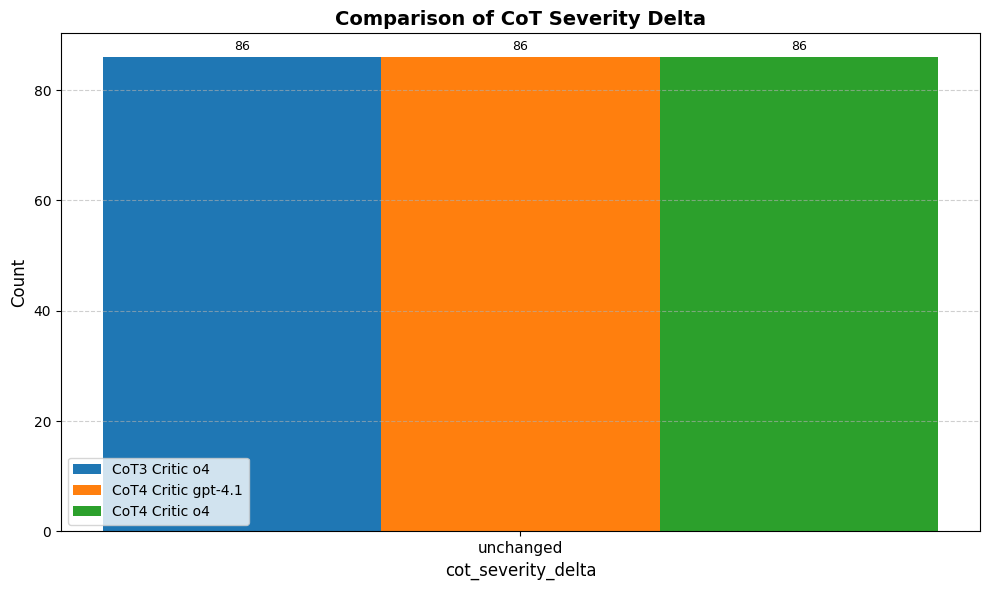

In [41]:
from utils import plot_grouped_bar_counts

plot_grouped_bar_counts(dfs=[df3_o4, df4_gpt4_1, df4_o4],
                        column="cot_severity_delta", 
                        labels=["CoT3 Critic o4", "CoT4 Critic gpt-4.1", "CoT4 Critic o4"],
                        title="Comparison of CoT Severity Delta"
                        )

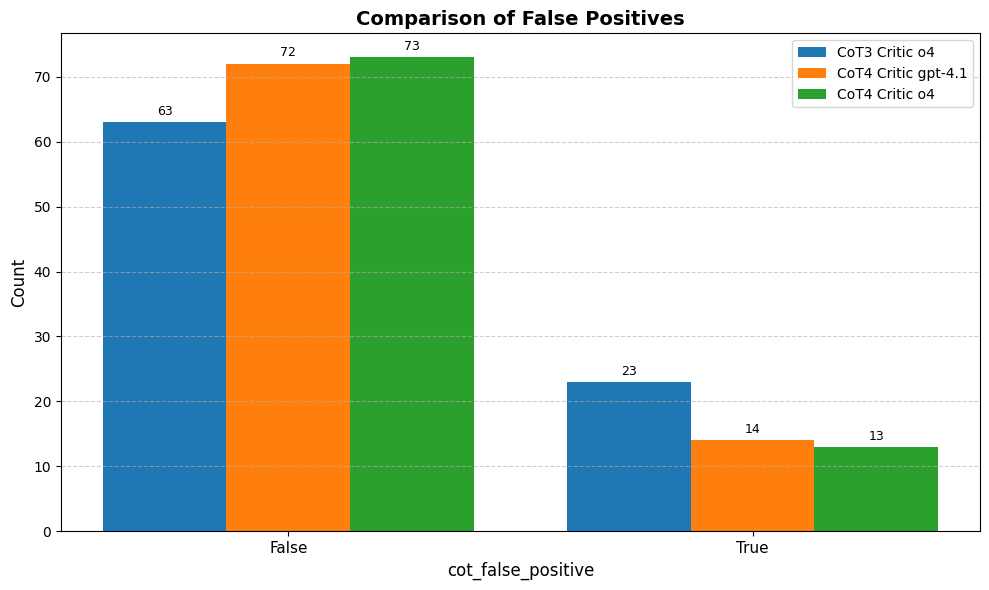

In [ ]:
from utils import plot_grouped_bar_counts

plot_grouped_bar_counts(dfs=[df3_o4, df4_gpt4_1, df4_o4],
                        column="cot_false_positive", 
                        labels=["CoT3 Critic o4", "CoT4 Critic gpt-4.1", "CoT4 Critic o4"],
                        title="Comparison of False Positives"
                        )

# AuditAgent Critic

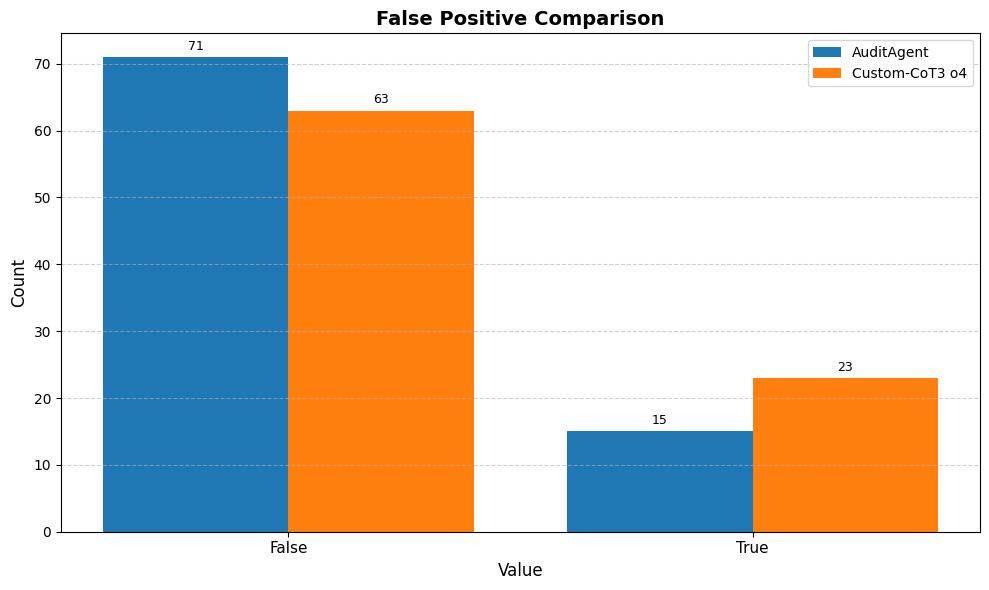

In [10]:
from utils import plot_grouped_bar_from_columns

plot_grouped_bar_from_columns(
    df=df3_o4,
    columns=["v1_false_positive", "cot_false_positive"],
    labels=["AuditAgent", "Custom-CoT3 o4"],
    title="False Positive Comparison"
)

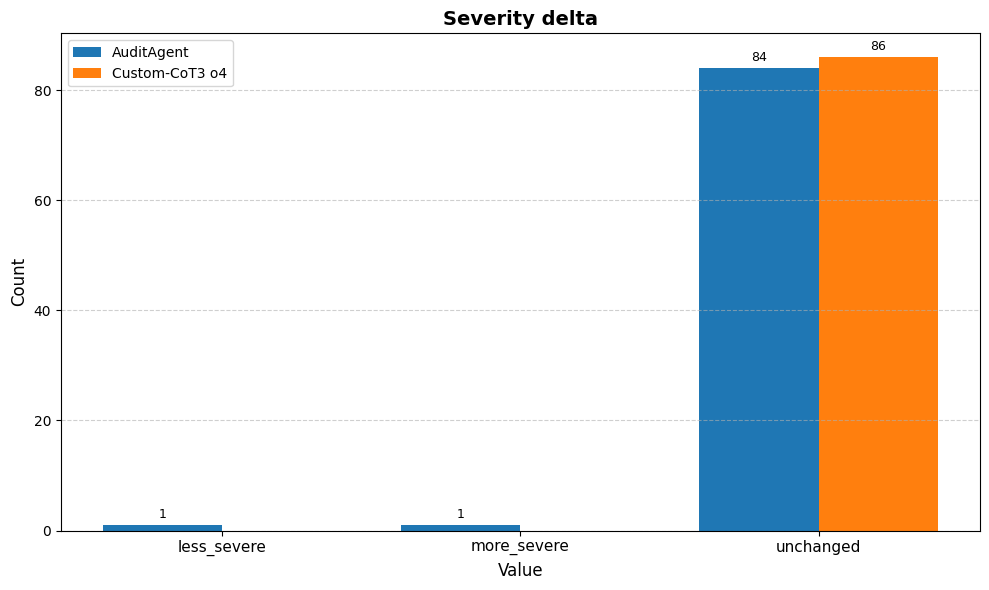

In [11]:
from utils import plot_grouped_bar_from_columns

plot_grouped_bar_from_columns(
    df=df3_o4,
    columns=["v1_severity_delta", "cot_severity_delta"],
    labels=["AuditAgent", "Custom-CoT3 o4"],
    title="Severity delta"
)